**Import Packages and files**

In [100]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import time    
from glob import glob
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

%matplotlib inline

**Unzip Files and Load Data**

In [101]:
from google.colab import drive
import os
import shutil 
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/Tumor_Detection/DataSet.zip" -d "/content/drive/My Drive/Tumor_Detection/Data/"

# feel free to edit this cell to work with your local or colab directory
WORKING_DIR = '/content/drive/My Drive/Tumor_Detection/Data/'
TRAIN_DIR = '/content/drive/My Drive/Tumor_Detection/Data/train'
VAL_DIR = '/content/drive/My Drive/Tumor_Detection/Data/val'


Mounted at /content/drive
Archive:  /content/drive/My Drive/Tumor_Detection/DataSet.zip
   creating: /content/drive/My Drive/Tumor_Detection/Data/no/
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no0.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no10.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no100.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1000.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1001.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1002.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1003.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1004.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1005.jpg  
  inflating: /content/drive/My Drive/Tumor_Detection/Data/no/no1006.jpg  
  inflating: /content/drive/My Drive/Tumor_De

In [102]:
shutil.move(os.path.join(WORKING_DIR,'yes'), os.path.join(TRAIN_DIR, 'yes'))
shutil.move(os.path.join(WORKING_DIR,'no'), os.path.join(TRAIN_DIR, 'no'))

'/content/drive/My Drive/Tumor_Detection/Data/train/no'

**Split Datasett**

In [103]:
from glob import glob
from sklearn.model_selection import train_test_split

## Randomly Split data into training and validation
# This code randomly chooses 75% and 25% of the MerchData to be set 
# as training and validation data, creates a train and a val folder.
yes = glob(TRAIN_DIR + '/yes/*.jpg')
no = glob(TRAIN_DIR + '/no/*.jpg')

# The *_val variables contain the filenames of the files chosen for validation. 
yes_train, yes_val = train_test_split(yes, test_size=0.25)
no_train, no_val = train_test_split(no, test_size=0.25)
# This code moves the validation files out of the train directory and over to 
# the val directory.
os.makedirs(os.path.join(VAL_DIR,'yes'))
for file in yes_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'no'))
for file in no_val:
  os.rename(file, file.replace('train','val'))

**Data Augmentation**

In [104]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

WIDTH = 240
HEIGHT = 240
BATCH_SIZE = 11

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2250 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


**Data Preprocessing**

In [105]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    """if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()"""
    
    return new_image

**Model Implementation and Training**

In [146]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input

base_model = InceptionV3(weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [153]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

CLASSES = 2
# These layers were removed by setting include_top=false, but we still want them
x = base_model.output                          # The output layer of the googleNet
x = GlobalAveragePooling2D(name='avg_pool')(x) # This layer is used to downsample the features
x = Dropout(0.4)(x)                            # This layer is used to enforce feature redundancy 

# This layer specifies our classifier output
predictions = Dense(CLASSES, activation='softmax')(x)
#
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [164]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [170]:
EPOCHS = 30
BATCH_SIZE = 32
STEPS_PER_EPOCH = 5
VALIDATION_STEPS = 1
MODEL_FILE = os.path.join(WORKING_DIR,'model')

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/30
5/5 [==============================] - 3s 569ms/step - loss: 0.2798 - accuracy: 0.8909 - val_loss: 0.0573 - val_accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 2s 385ms/step - loss: 0.3395 - accuracy: 0.8909 - val_loss: 0.4128 - val_accuracy: 0.8182
Epoch 3/30
5/5 [==============================] - 2s 389ms/step - loss: 0.4672 - accuracy: 0.7818 - val_loss: 0.4289 - val_accuracy: 0.8182
Epoch 4/30
5/5 [==============================] - 2s 399ms/step - loss: 0.2510 - accuracy: 0.8727 - val_loss: 0.2159 - val_accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 2s 401ms/step - loss: 0.2071 - accuracy: 0.8909 - val_loss: 0.1040 - val_accuracy: 0.9091
Epoch 6/30
5/5 [==============================] - 2s 390ms/step - loss: 0.3101 - accuracy: 0.8909 - val_loss: 0.2369 - val_accuracy: 0.9091
Epoch 7/30
5/5 [==============================] - 2s 399ms/step - loss: 0.3753 - accuracy: 0.8000 - val_loss: 0.2787 - val_accuracy: 0.8182
Epoch 8/30
5/5 [====

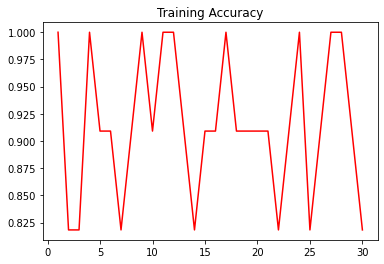

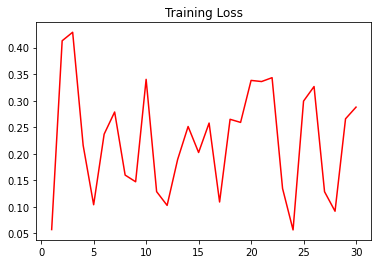

In [171]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r')
plt.title("Training Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.title("Training Loss")
plt.show()

In [99]:
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.
